# Mass-Spring-Damper System: Generating Training and Test Data

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')



### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
# from PCAfold         import PCA          as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
OutputDir   = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/StiffKinetics_5000Cases/')
FigDir      = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

n_training  = 5000
n_test      = 50

Nt          = 1000
tout        = np.logspace(-8,0,Nt)
tout_test   = np.logspace(-8,np.log10(500.),Nt)
SOLVER      = 'Radau'

MinVals     = [0., 0., 0.]
MaxVals     = [1., 1.e-4, 1.]


ColorVec    = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

OutputDir += '/Orig/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass

TempDir = OutputDir+'/train/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = OutputDir+'/test/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

TempDir = TempDir+'/ext/'
try:
    os.makedirs(TempDir)
except OSError as e:
    pass

## ODE

In [3]:
def fOrig(t, y):
    return [-Params[0]*y[0] + Params[2]*y[1]*y[2], 
             Params[0]*y[0] - Params[1]*y[1]**2 - Params[2]*y[1]*y[2],
             Params[1]*y[1]**2]

Params = np.array([0.04, 3.e7, 1e4], dtype=np.float64)

## Sampling and Plotting Initial Conditions

In [4]:
### From Uniform Distibutions

# y0Mat      = np.zeros((n_training,2))
# y0Mat[:,0] = np.random.rand(n_training)*4. - 2.0
# y0Mat[:,1] = np.random.rand(n_training)*4. - 2.0

# y0MatTest      = np.zeros((n_test,2))
# y0MatTest[:,0] = np.random.rand(n_test)*4. - 2.0
# y0MatTest[:,1] = np.random.rand(n_test)*2. - 1.0


### From Latin Hypercube 

y0Mat      = np.zeros((n_training,3))
y0Mat[:,0] = np.random.rand(n_training)*0.9999
y0Mat[:,2] = np.random.rand(n_training)*1.e-4
y0Mat[:,1] = 1. - (y0Mat[:,0]+y0Mat[:,2])

y0MatTest      = np.zeros((n_test,3))
y0MatTest[:,0] = np.random.rand(n_test)*0.9999
y0MatTest[:,2] = np.random.rand(n_test)*1.e-4
y0MatTest[:,1] = 1. - (y0MatTest[:,0]+y0MatTest[:,2])

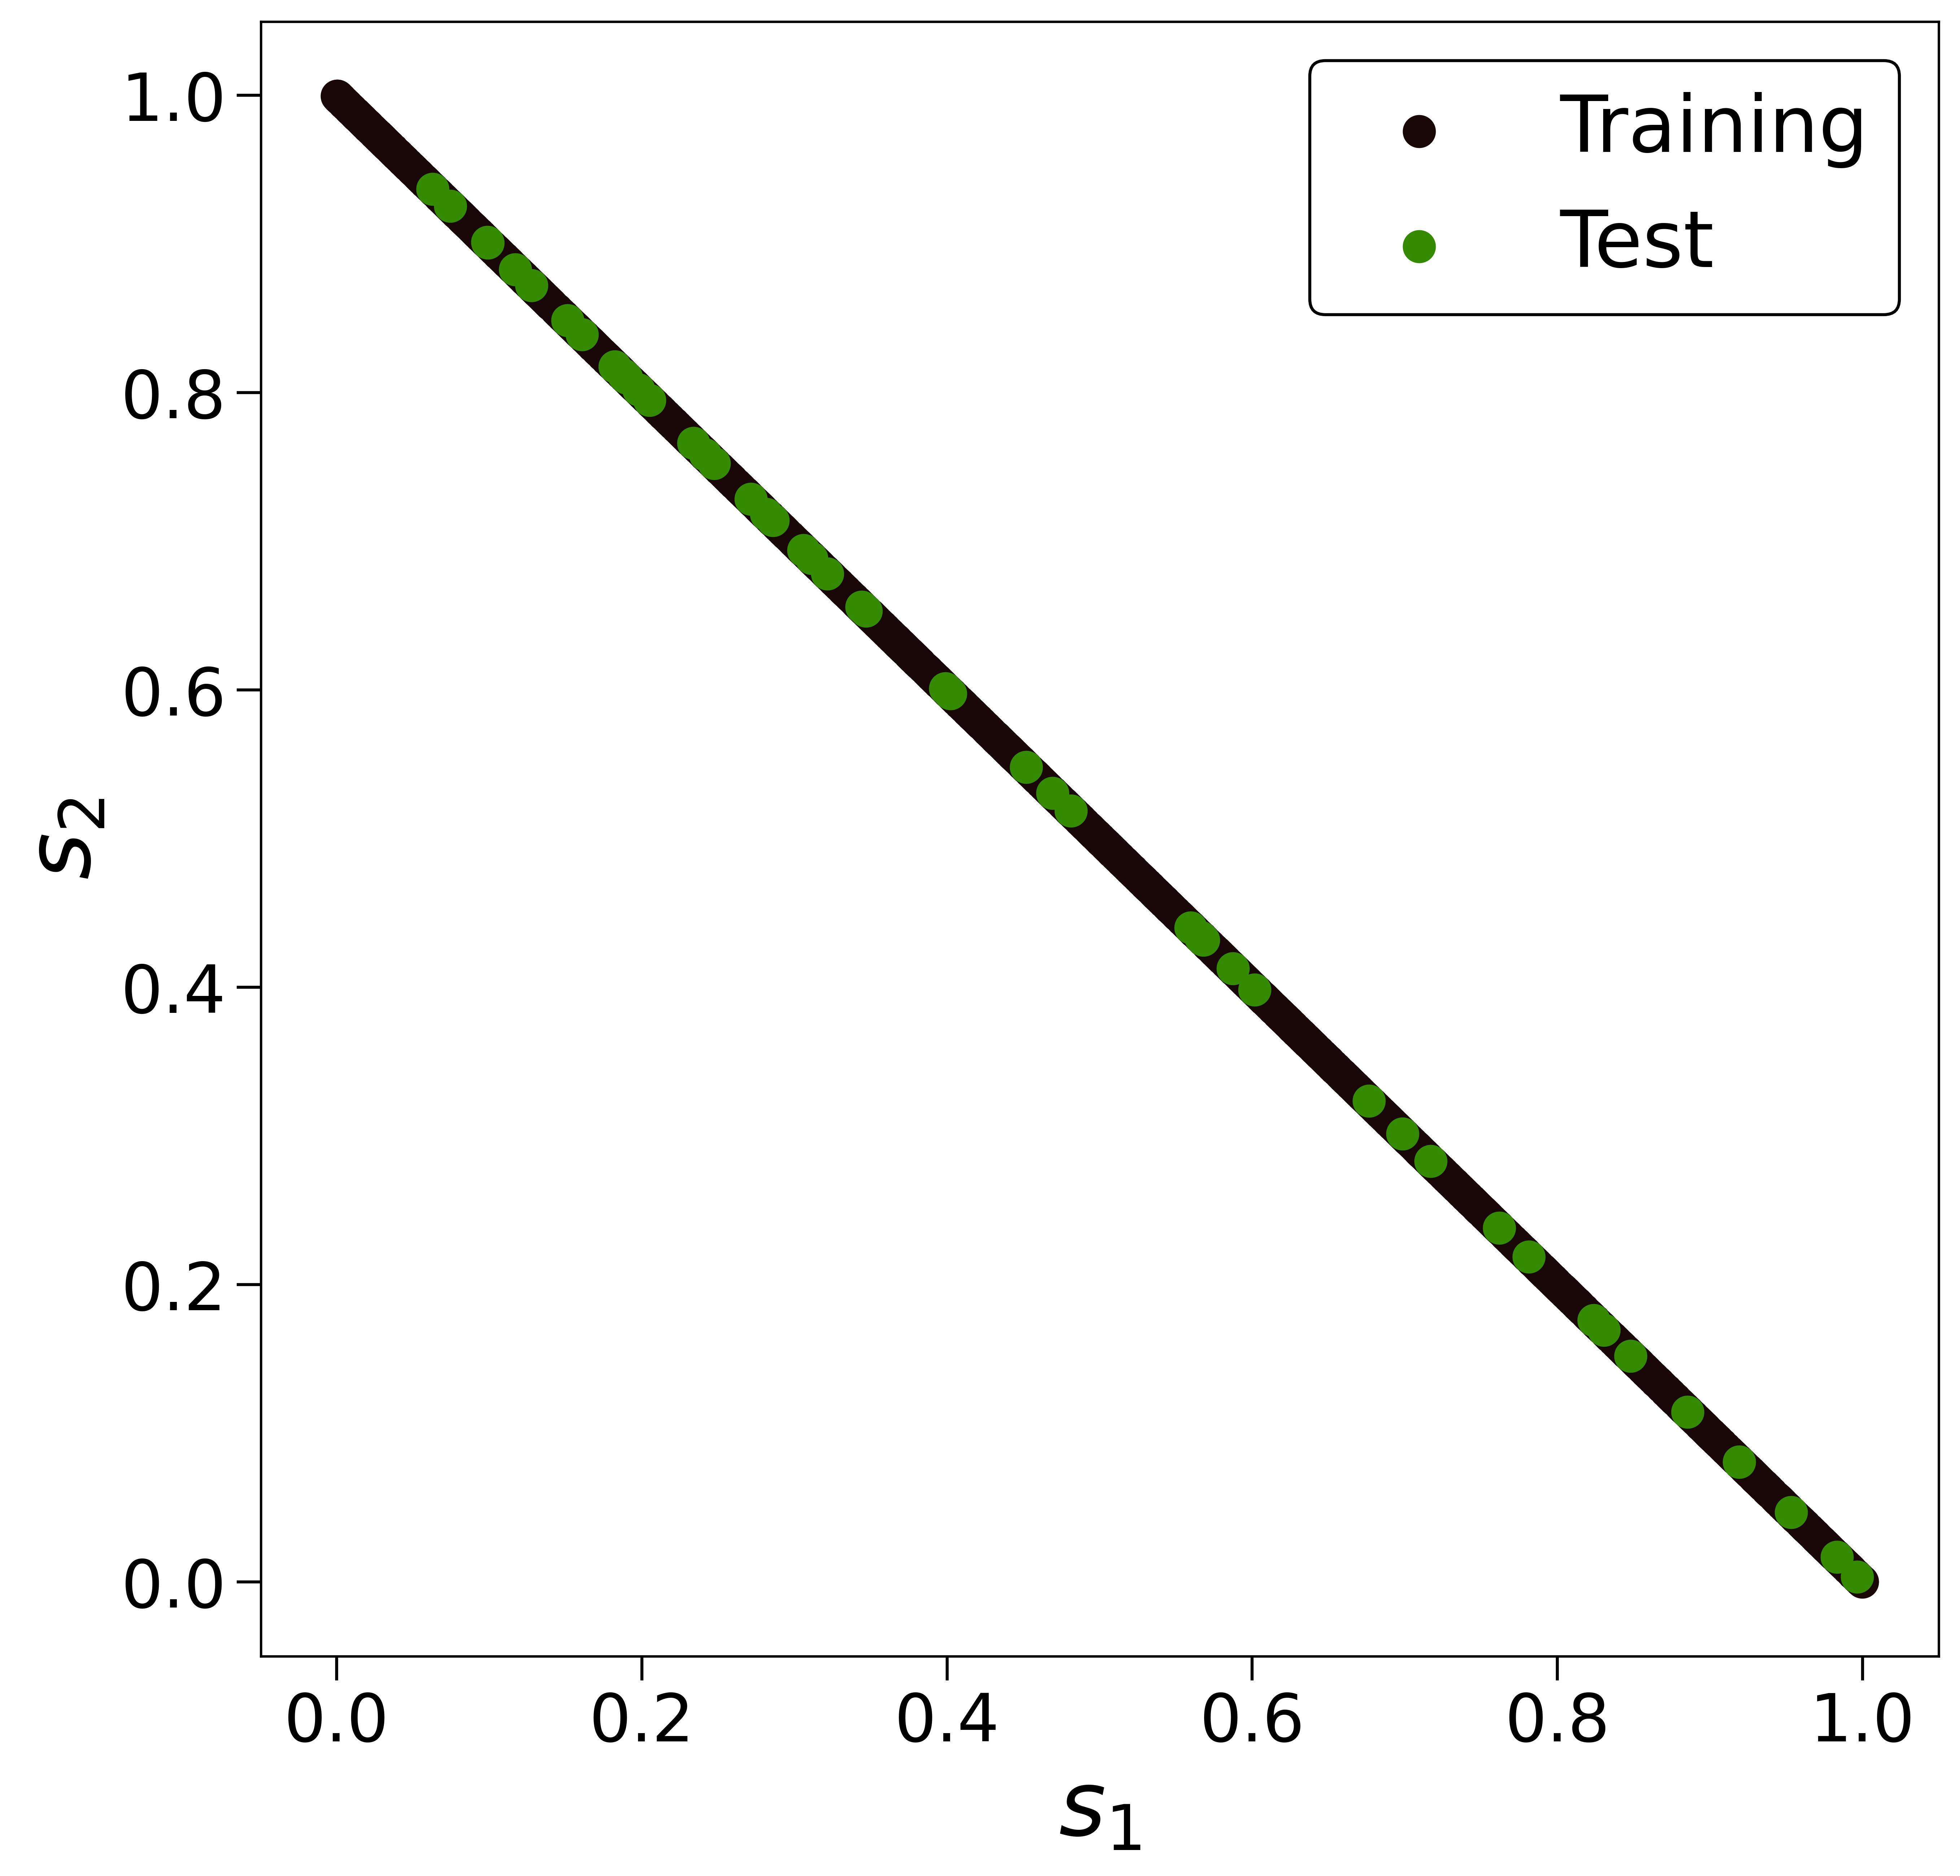

In [5]:
plt.figure()
plt.scatter(y0Mat[:,0],     y0Mat[:,1],                    label='Training')
plt.scatter(y0MatTest[:,0], y0MatTest[:,1], c=ColorVec[3], label='Test')
plt.xlabel('$s_1$')
plt.ylabel('$s_2$')
plt.legend()

if (FigDir):
    plt.savefig(FigDir+'/MSD_ICs.eps', format='eps', bbox_inches='tight')

## Generating Training Data

<ipython-input-6-360677e02de0>:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0.,1.])


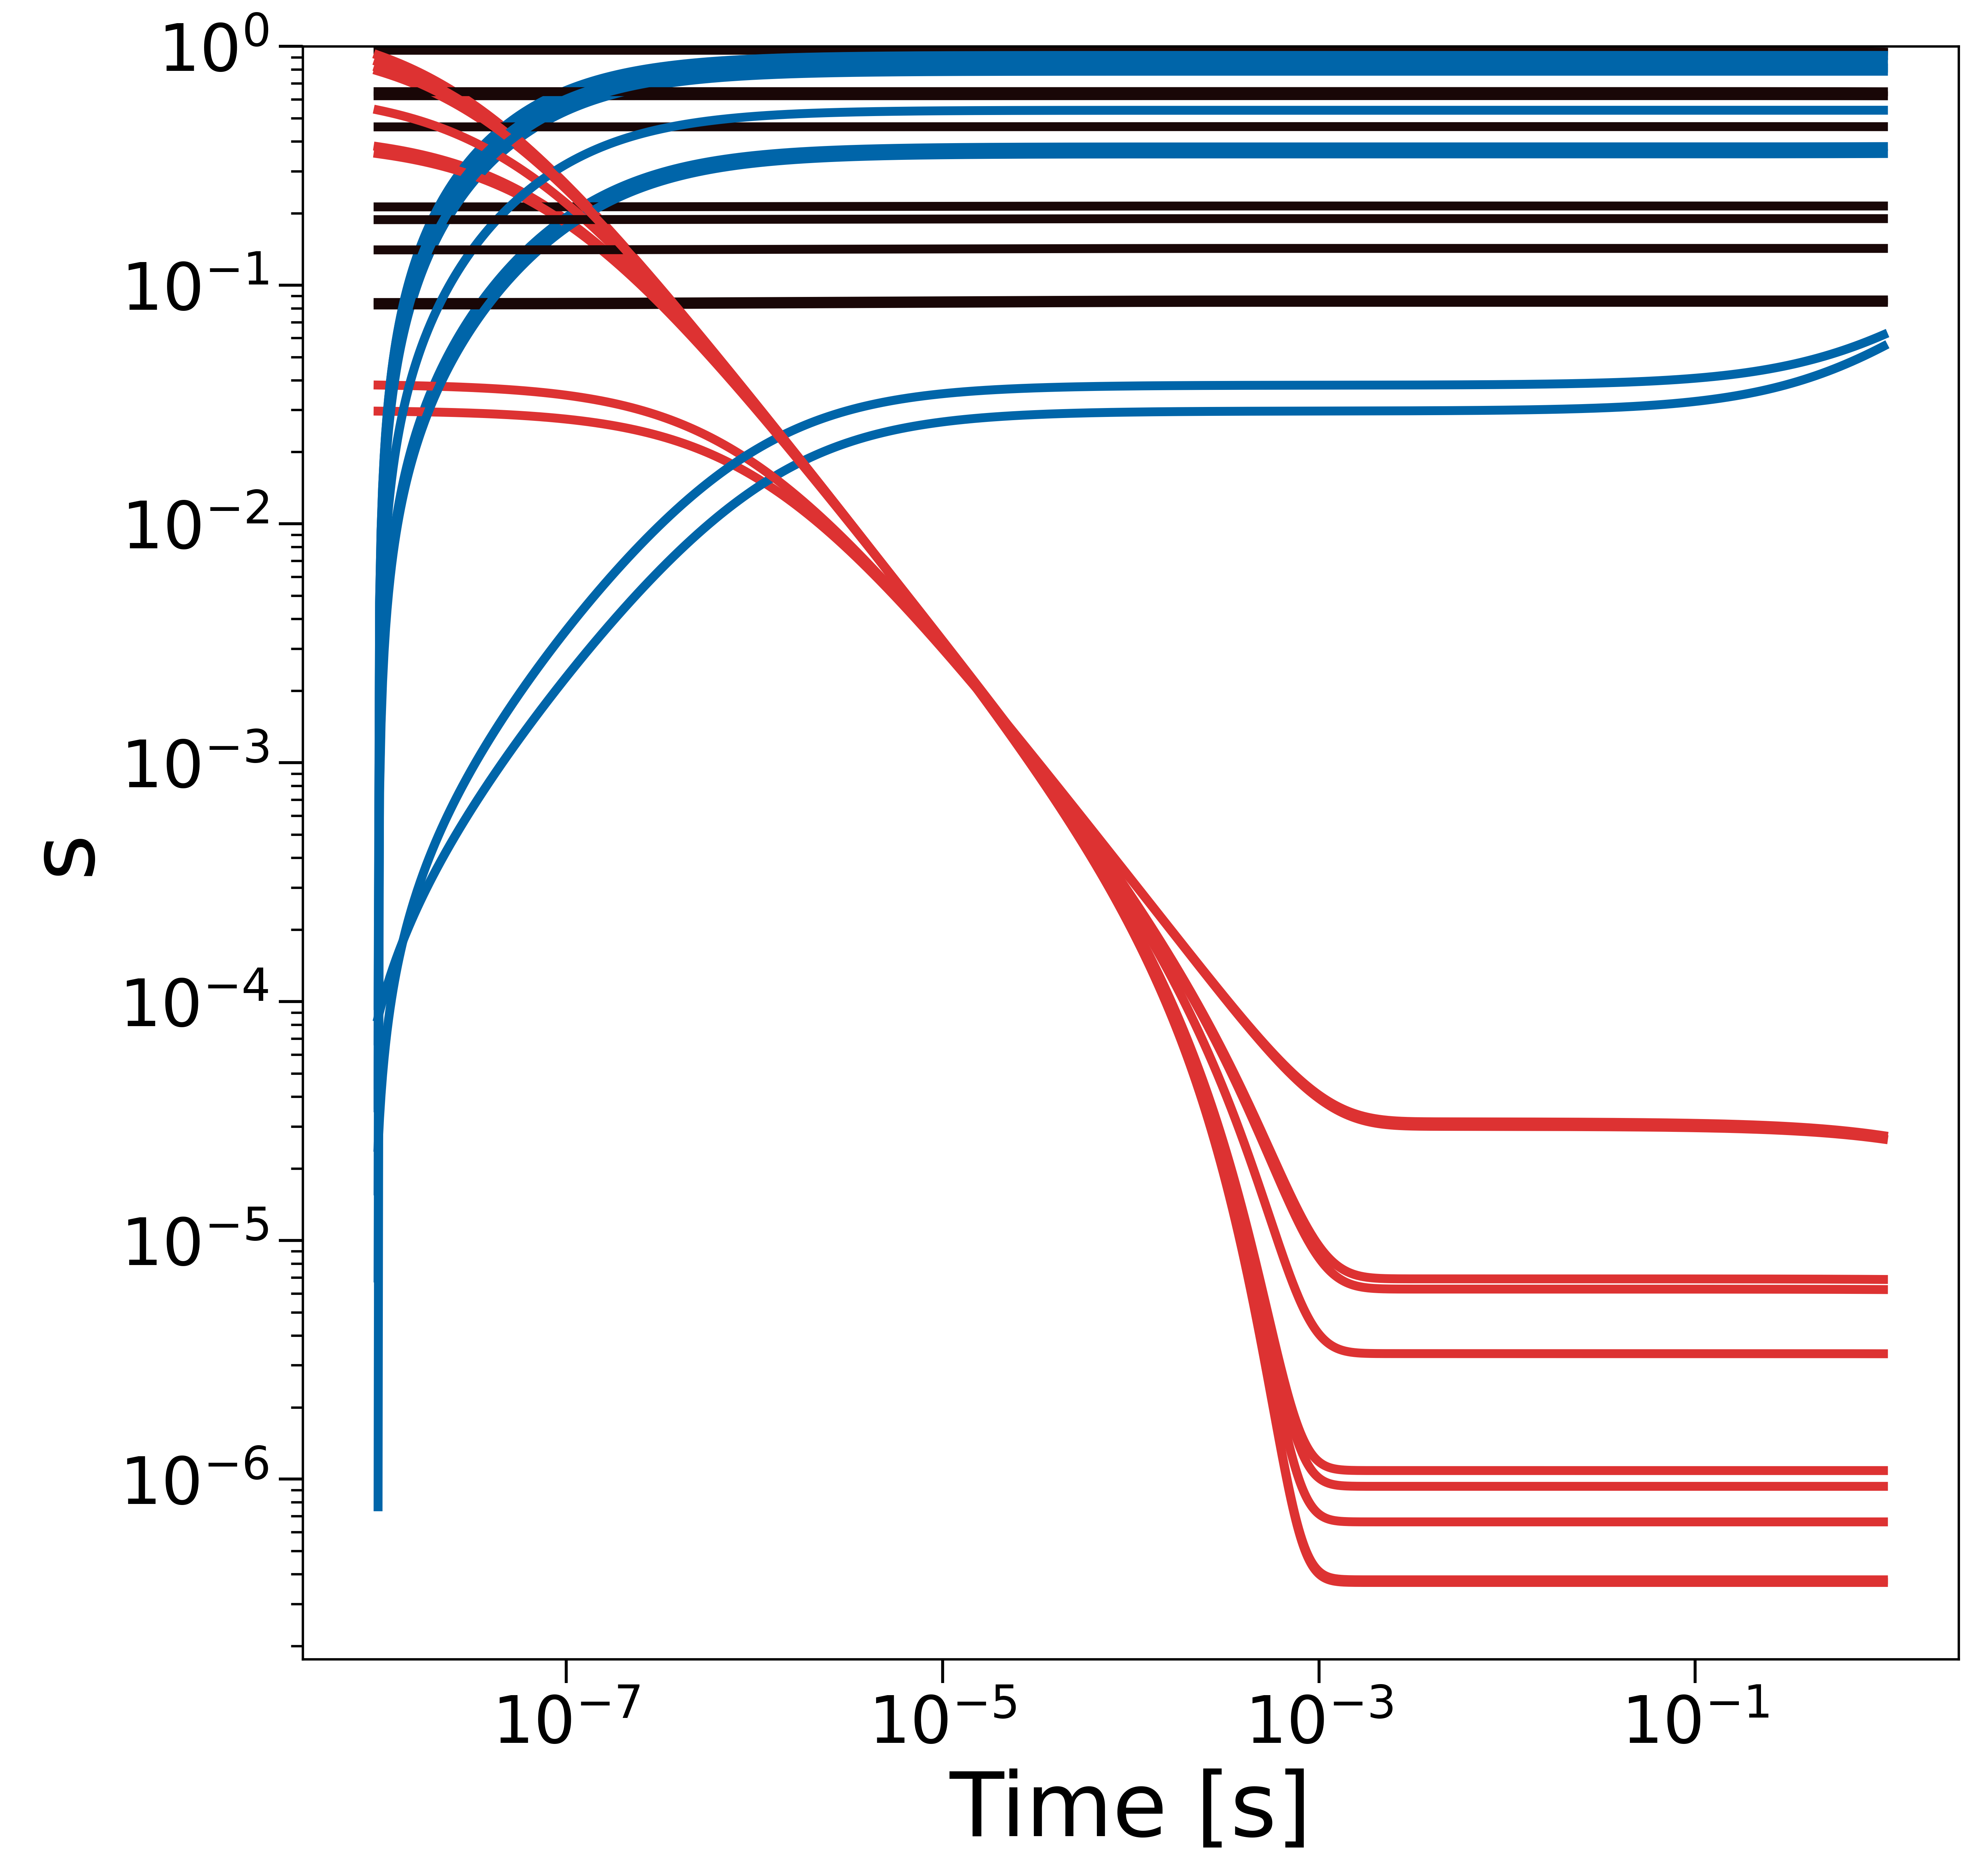

In [6]:
fig = plt.figure()
for iSample in range(n_training):
    y0         = y0Mat[iSample,:]
    #print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-12, atol=1.e-12 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    if (iSample%500 == 0):
        plt.plot(output.t, output.y[0,:], color=ColorVec[0])
        plt.plot(output.t, output.y[1,:], color=ColorVec[1])
        plt.plot(output.t, output.y[2,:], color=ColorVec[2])

    if (iSample == 0):
        tMat    = tMatTemp
        uMat    = uMatTemp
        yMat    = output.y.T 
    else:
        tMat    = np.concatenate((tMat,    tMatTemp), axis=0)
        uMat    = np.concatenate((uMat,    uMatTemp), axis=0)
        yMat    = np.concatenate((yMat,    output.y.T), axis=0)

    #Header   = 't,s1,s2,s3'
    #FileName = OutputDir+'/train/ext/y.csv.'+str(iSample+1)
    #np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('s')
plt.ylim([0.,1.])

if (FigDir):
    plt.savefig(FigDir+'/StiffKinetics_TrainDynamics.eps', format='eps', bbox_inches='tight')

## Splitting and Writing Training Data

In [7]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/valid/')
except:
    pass

In [8]:
data_id    = 'pts'

DataInput  = pd.DataFrame(np.concatenate((tMat,uMat), axis=1), columns=['t','s1','s2','s3'])
DataOutput = pd.DataFrame(np.concatenate((tMat,yMat), axis=1), columns=['t','s1','s2','s3'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

In [9]:
data_id    = 'ics'

t0Mat      = np.zeros((y0Mat.shape[0],1)) + 1.e-14
u0Mat      = y0Mat

DataInput  = pd.DataFrame(np.concatenate((t0Mat,u0Mat), axis=1), columns=['t','s1','s2','s3'])
DataOutput = pd.DataFrame(np.concatenate((t0Mat,u0Mat), axis=1), columns=['t','s1','s2','s3'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

In [10]:
tMat_res = []
for i in range(n_training):
    tMat_res.append(np.random.rand(Nt))
tMat_res = np.stack(tMat_res, axis=0)
tMat_res = tMat_res.reshape((tMat_res.shape[0]*tMat_res.shape[1],1))

In [11]:
data_id    = 'res'

DataInput  = pd.DataFrame(np.concatenate((tMat_res,uMat), axis=1),    columns=['t','s1','s2','s3'])
DataOutput = pd.DataFrame(np.concatenate((tMat_res,yMat*0.), axis=1), columns=['t','s1','s2','s3'])
                          
n_points   = len(DataInput)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=0.2, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)

try:
    os.makedirs(OutputDir+'/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/valid/'+data_id+'/')
except:
    pass

DataInput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Input.csv', index=False)

DataOutput.iloc[train_idx].to_csv(OutputDir+'/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/valid/'+data_id+'/Output.csv', index=False)

## Generating Test Data

<ipython-input-12-0187b259f4e3>:34: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0.,1.])


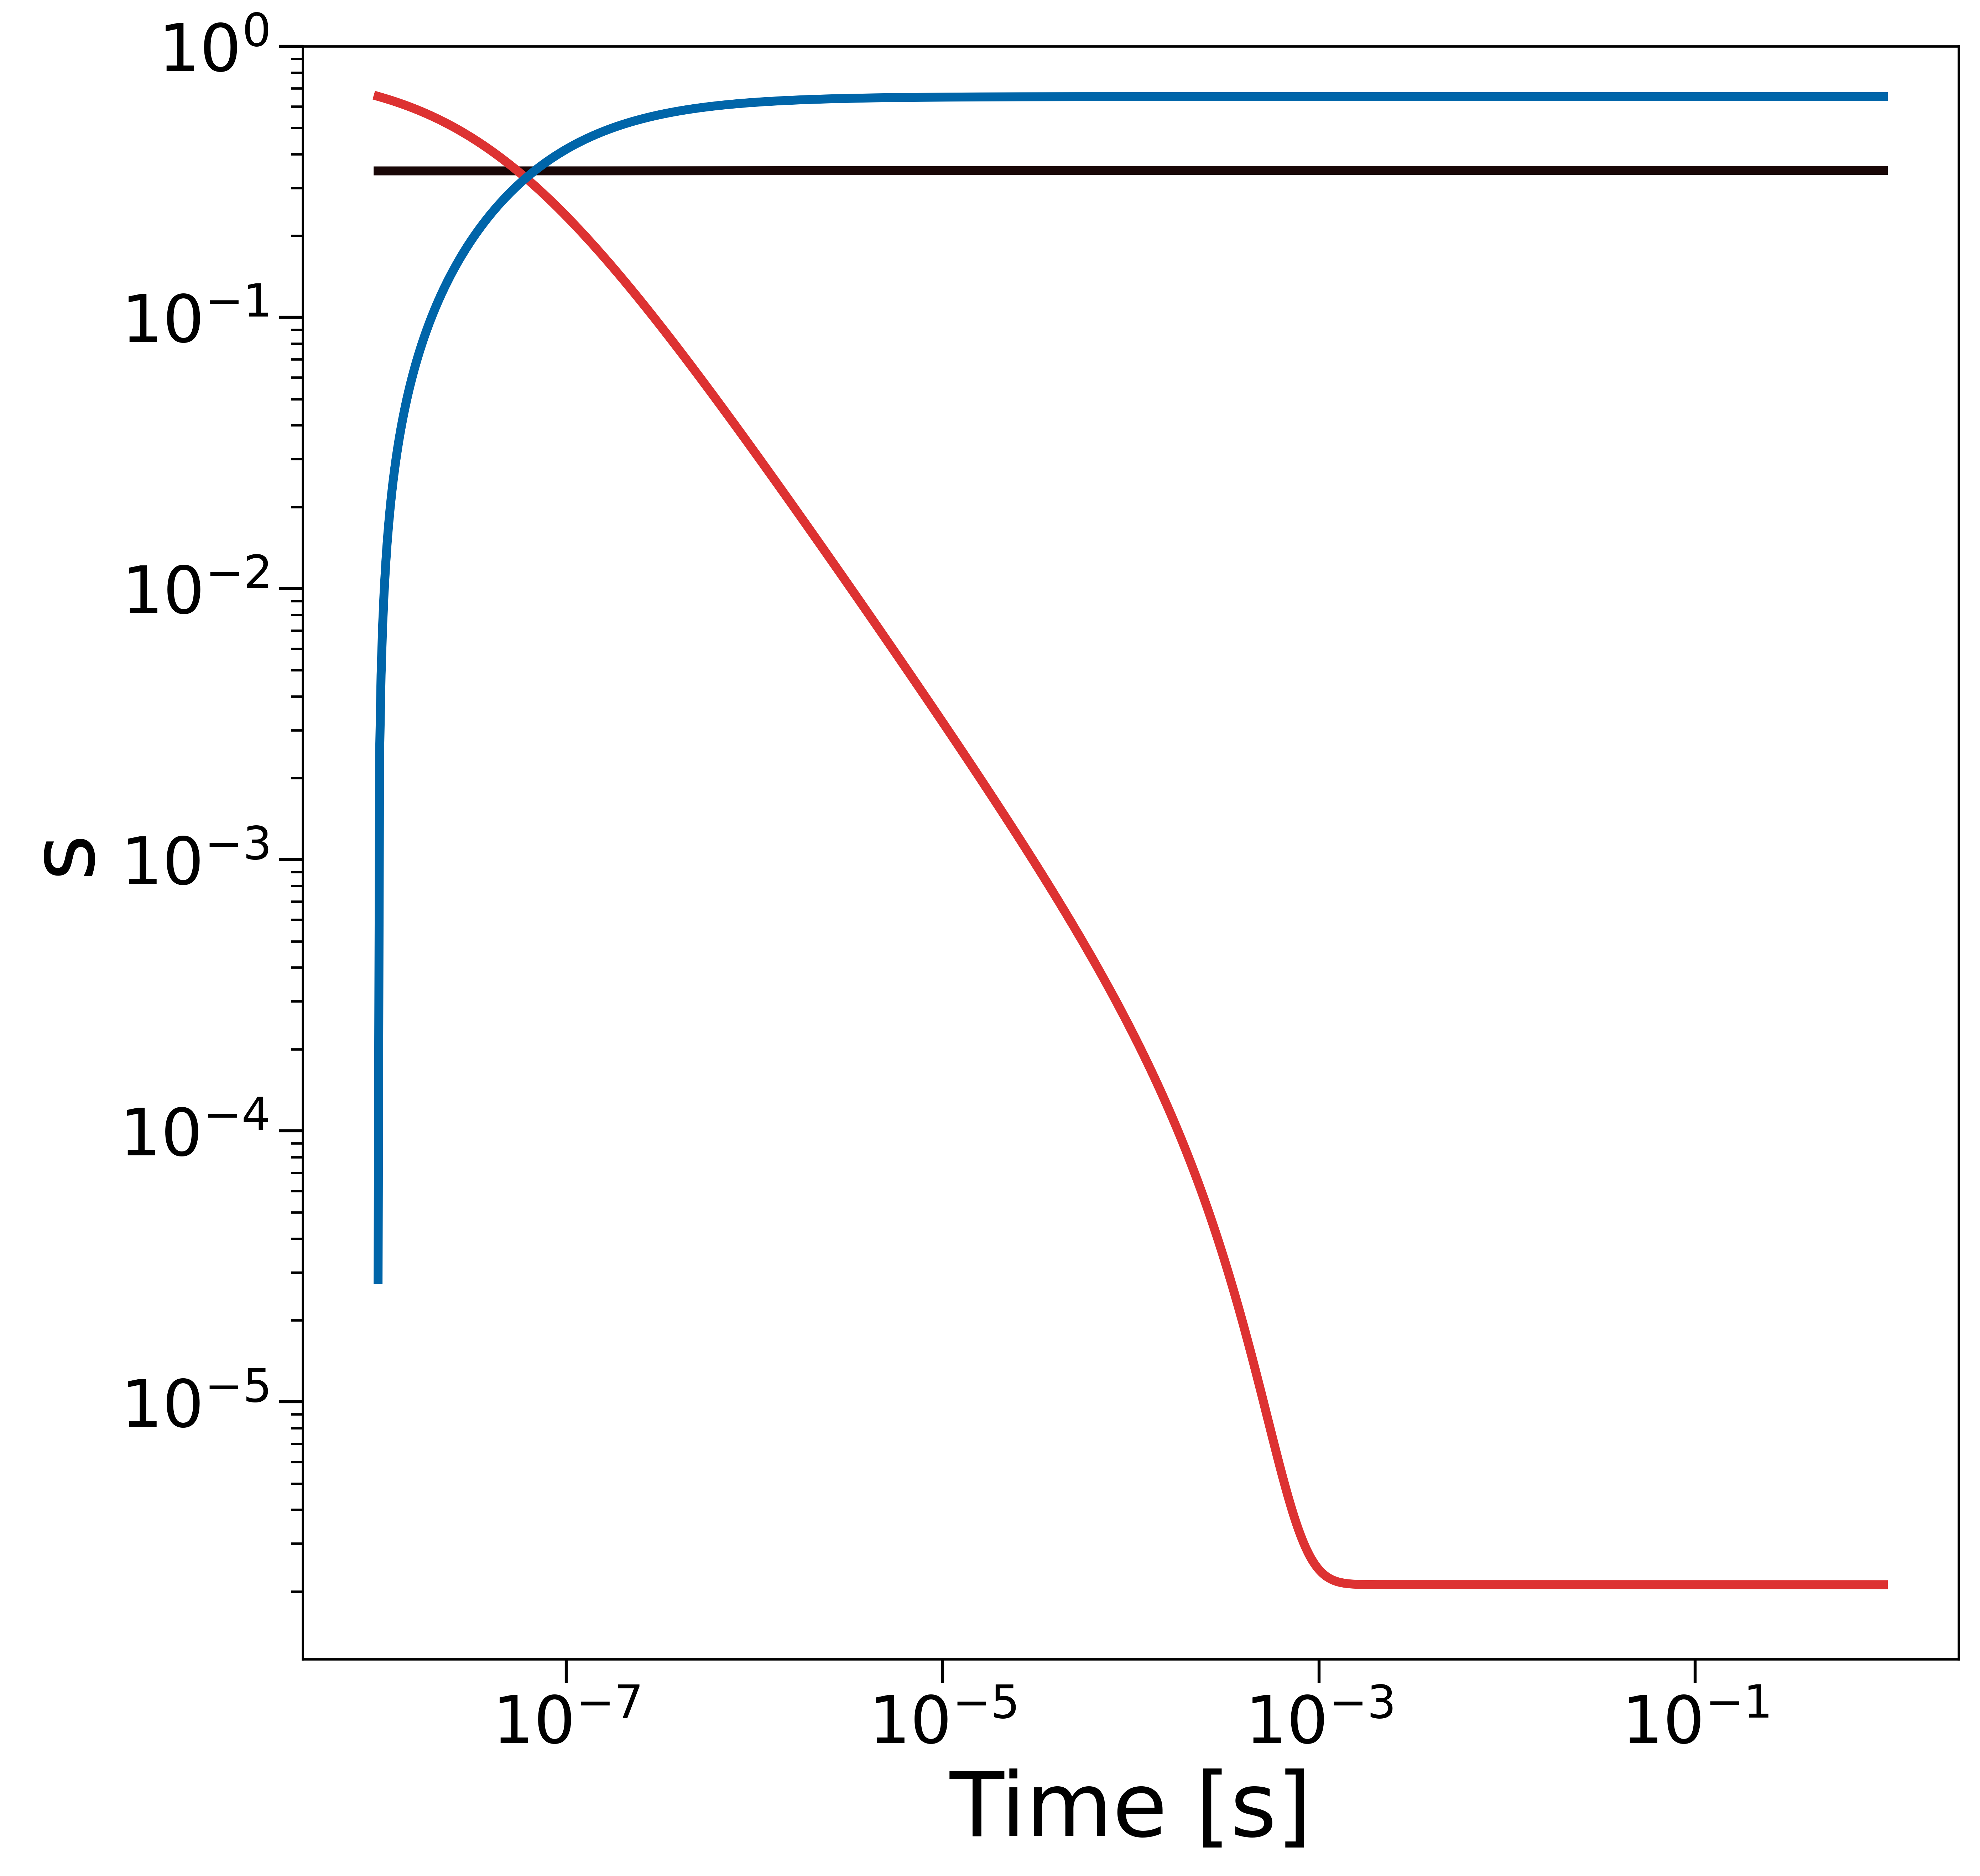

In [12]:
fig = plt.figure()
for iSample in range(n_test):
    y0         = y0MatTest[iSample,:]
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-12, atol=1.e-12 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    if (iSample%50 == 0):
        plt.plot(output.t, output.y[0,:], color=ColorVec[0])
        plt.plot(output.t, output.y[1,:], color=ColorVec[1])
        plt.plot(output.t, output.y[2,:], color=ColorVec[2])
    

    if (iSample == 0):
        tMatTest    = tMatTemp
        uMatTest    = uMatTemp
        yMatTest    = output.y.T 
    else:
        tMatTest    = np.concatenate((tMatTest,    tMatTemp), axis=0)
        uMatTest    = np.concatenate((uMatTest,    uMatTemp), axis=0)
        yMatTest    = np.concatenate((yMatTest,    output.y.T), axis=0)
        
    #Header   = 't,s1,s2,s3'
    #FileName = OutputDir+'/test/ext/y.csv.'+str(iSample+1)
    #np.savetxt(FileName, np.concatenate((tMatTemp,output.y.T), axis=1), delimiter=',', header=Header, comments='')
        

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('s')
plt.ylim([0.,1.])


if (FigDir):
    plt.savefig(FigDir+'/StiffKinetics_TestDynamics.eps', format='eps', bbox_inches='tight')

## Writing Test Data

In [13]:
TestDir  = OutputDir+'/test/ext/'

Header   = 't,s1,s2,s3'
FileName = TestDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMatTest,uMatTest), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 't,s1,s2,s3'
FileName = TestDir+'/Output.csv'
np.savetxt(FileName, np.concatenate((tMatTest,yMatTest), axis=1), delimiter=',', header=Header, comments='')

In [ ]:
tout = np.logspace(-7.,40.,5000)

fig  = plt.figure()
for iSample in range(n_test):    
    output     = solve_ivp( fOrig, [tout[0],tout[-1]], [1., 0., 0.], method=SOLVER, t_eval=tout, rtol=1.e-12, atol=1.e-16 )
    
    plt.plot(output.t, output.y[0,:], color=ColorVec[0])
    plt.plot(output.t, output.y[1,:], color=ColorVec[1])
    plt.plot(output.t, output.y[2,:], color=ColorVec[2])

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('s')
#plt.xlim([0.,40.])
plt.ylim([0.,1.])

/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/radau.py:320: LinAlgWarning: Diagonal number 3 is exactly zero. Singular matrix.
  return lu_factor(A, overwrite_a=True)
<ipython-input-3-886c86489742>:2: RuntimeWarning: invalid value encountered in double_scalars
  return [-Params[0]*y[0] + Params[2]*y[1]*y[2],
<ipython-input-3-886c86489742>:3: RuntimeWarning: invalid value encountered in double_scalars
  Params[0]*y[0] - Params[1]*y[1]**2 - Params[2]*y[1]*y[2],
